In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dimpo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# FIRST TRY WITH FULL ANNOTATIONS

In [185]:
lor=pd.read_excel("for_annotations_relations_lorenzo_try.xlsx")
ric=pd.read_excel("annotations 2000.xlsx")
ric=ric.iloc[0:2000,:]
lor=lor.iloc[0:2170,:]

In [58]:
ric.drop(['Column1'],axis=1,inplace=True)
lor.drop(['Unnamed: 0'],axis=1,inplace=True)

In [59]:
final=pd.concat([lor,ric]).reset_index(drop=True)

In [60]:
final.loc[1693,"is_valuable"]=1

In [61]:
final["is_valuable_rel"]=[1 for i in range(len(final))]
final["is_valuable_arg2"]=[1 for i in range(len(final))]

In [62]:
final.to_excel("final.xlsx")

<AxesSubplot: xlabel='is_valuable', ylabel='Count'>

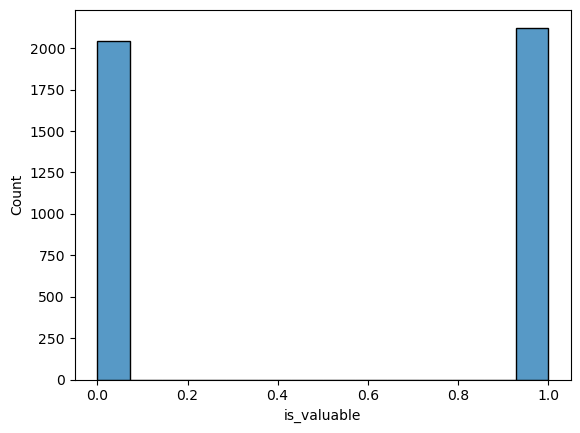

In [50]:
sns.histplot(final["is_valuable"])

In [51]:
final["len_arg1"]=final["arg1"].apply(lambda x: len(word_tokenize(x)))
final["len_rel"]=final["rel"].apply(lambda x: len(word_tokenize(x)))
final["len_arg2"]=final["arg2"].apply(lambda x: len(word_tokenize(x)))

In [38]:

model = SentenceTransformer('all-MiniLM-L6-v2')
final.loc[:, 'arg1'] = final.loc[:, 'arg1'].apply(lambda x: model.encode(x))
final.loc[:, 'rel'] = final.loc[:, 'rel'].apply(lambda x: model.encode(x))
final.loc[:, 'arg2'] = final.loc[:, 'arg2'].apply(lambda x: model.encode(x))

In [39]:
embeddings_arg1 = np.vstack(final.loc[:, 'arg1'].values)
embeddings_rel = np.vstack(final.loc[:, 'rel'].values)
embeddings_arg2 = np.vstack(final.loc[:, 'arg2'].values)

In [40]:
# final.loc[:, 'negated']=final.loc[:, 'negated'].apply(lambda x: 1 if x==True else 0)
# final.loc[:, 'passive']=final.loc[:, 'passive'].apply(lambda x: 1 if x==True else 0)
# negated = np.expand_dims(final.loc[:, 'negated'].values, axis=1)
# passive = np.expand_dims(final.loc[:, 'passive'].values, axis=1)
confidence= final.loc[:, ['confidence']].values
len_arg1 = np.expand_dims(final.loc[:, 'len_arg1'].values, axis=1)
len_rel = np.expand_dims(final.loc[:, 'len_rel'].values, axis=1)
len_arg2 = np.expand_dims(final.loc[:, 'len_arg2'].values, axis=1)


In [41]:
# X = np.hstack([embeddings_arg1, embeddings_rel, embeddings_arg2, negated, passive, confidence])
X = np.hstack([embeddings_arg1, embeddings_rel, embeddings_arg2, confidence, len_arg1, len_rel, len_arg2])

In [54]:
X=final.drop(['is_valuable', 'sentence', 'arg1', 'rel', 'arg2', 'negated', 'passive'],axis=1)

In [42]:
y=final.loc[:, 'is_valuable'].astype(int)

In [56]:


# Create a Random Forest Classifier with desired parameters
rf_classifier = RandomForestClassifier(random_state=42)
score = cross_val_score(rf_classifier, X, y, cv=5,error_score='raise')
score

array([0.56115108, 0.55635492, 0.56354916, 0.52278177, 0.55395683])

In [117]:
rf=RandomForestClassifier(random_state=42)
rf.fit(X,y)

RandomForestClassifier(random_state=42)

In [118]:
from joblib import dump
dump(rf, 'model_file.joblib')

['model_file.joblib']

# SECOND TRY WITH MORE CLASSIFIERS

In [211]:
mie = pd.read_excel("final.xlsx")
ric = pd.read_csv("150ric.csv")
ele = pd.read_csv("150ele.csv")
domi = pd.read_csv("150domi.csv")
mie.drop(['Unnamed: 0'],axis=1,inplace=True)
ele.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1,inplace=True)

In [212]:
mie=mie.iloc[:605,:]
mie.drop(mie[mie["is_valuable"] == "q"].index, inplace = True)
mie["negated"]=mie["negated"].apply(lambda x: 1 if x==True else 0)
mie["passive"]=mie["passive"].apply(lambda x: 1 if x==True else 0)
ele["negated"]=ele["negated"].apply(lambda x: 1 if x==True else 0)
mie["passive"]=mie["passive"].astype(float)
mie["negated"]=mie["negated"].astype(float)
ele["negated"]=ele["negated"].astype(float)
ele["is_valuable"]=ele["is_valuable"].astype(float)
mie["is_valuable"]=mie["is_valuable"].astype(float)
ele["is_valuable_rel"]=ele["is_valuable_rel"].astype(float)
mie["is_valuable_rel"]=mie["is_valuable_rel"].astype(float)
ele["is_valuable_arg2"]=ele["is_valuable_arg2"].astype(float)
mie["is_valuable_arg2"]=mie["is_valuable_arg2"].astype(float)
ric.rename(columns={"arg1_val": "is_valuable","rel_val":"is_valuable_rel","arg2_val":"is_valuable_arg2"},inplace=True)


In [213]:
final=pd.concat([mie,ric,ele,domi]).reset_index(drop=True)

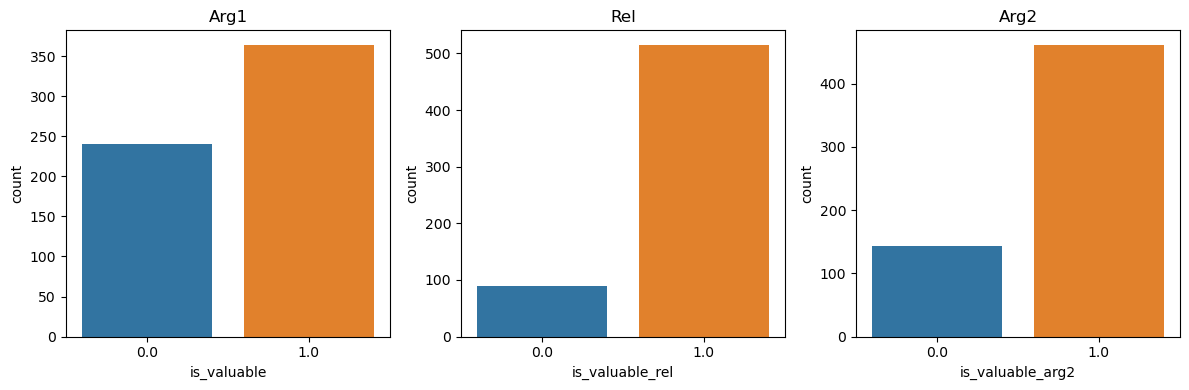

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.countplot(data=final, x='is_valuable', ax=axes[0])
axes[0].set_title('Arg1')
sns.countplot(data=final, x='is_valuable_rel', ax=axes[1])
axes[1].set_title('Rel')
sns.countplot(data=final, x='is_valuable_arg2', ax=axes[2])
axes[2].set_title('Arg2')
plt.tight_layout()
plt.show()


In [215]:
main_pos_tags = {'Noun': ['NN', 'NNS', 'NNP', 'NNPS'],
                 'Pronoun': ['PRP', 'PRP$'],
                 'Adjective': ['JJ', 'JJR', 'JJS'],
                 'Verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                 'Adverb': ['RB', 'RBR', 'RBS'],
                 'Determiner': ['DT', 'PDT', 'WDT'],
                 'Numeral': ['CD']
                }

def count_main_pos_tags(sentence):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
    tag_counts = {tag_group: 0 for tag_group in main_pos_tags}
    for word, tag in pos_tags:
        for tag_group, tags in main_pos_tags.items():
            if tag in tags:
                tag_counts[tag_group] += 1
    return tag_counts

In [200]:
def for_class(df,x):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    if x=="arg1":
        db=df[[x,"is_valuable"]]
    elif x=="rel":
        db=df[[x,"is_valuable_rel"]]
    elif x=="arg2":
        db=df[[x,"is_valuable_arg2"]]
    db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
    db['main_pos_counts'] = db[x].apply(count_main_pos_tags)
    db = pd.concat([db.drop('main_pos_counts', axis=1), db['main_pos_counts'].apply(pd.Series)], axis=1)
    db["rel_nouns"]=db["Noun"]/db["length"]
    db["rel_pronouns"]=db["Pronoun"]/db["length"]
    db["rel_adjectives"]=db["Adjective"]/db["length"]
    db["rel_verbs"]=db["Verb"]/db["length"]
    db["rel_adverbs"]=db["Adverb"]/db["length"]
    db["rel_determiners"]=db["Determiner"]/db["length"]
    db["rel_numerals"]=db["Numeral"]/db["length"]
    if x=="rel":
        db_majority = db[db['is_valuable_rel'] == 1]  # Majority class
        db_minority = db[db['is_valuable_rel'] == 0]  # Minority class
        db_majority_undersampled = resample(db_majority, replace=False, n_samples=len(db_minority))
        db = pd.concat([db_majority_undersampled, db_minority]).reset_index(drop=True)
        db_aux=db.copy()
    else:
        db_aux=None
    db.loc[:, x] = db.loc[:, x].apply(lambda x: model.encode(x))
    embeddings_arg1 = np.vstack(db.loc[:, x].values)
    len_arg1 = np.expand_dims(db.loc[:, 'length'].values, axis=1)
    nouns=np.expand_dims(db.loc[:, 'Noun'].values, axis=1)
    pronouns=np.expand_dims(db.loc[:, 'Pronoun'].values, axis=1)
    adjectives=np.expand_dims(db.loc[:, 'Adjective'].values, axis=1)
    verbs=np.expand_dims(db.loc[:, 'Verb'].values, axis=1)
    rel_nouns=np.expand_dims(db.loc[:, 'rel_nouns'].values, axis=1)
    rel_pronouns=np.expand_dims(db.loc[:, 'rel_pronouns'].values, axis=1)
    rel_adjectives=np.expand_dims(db.loc[:, 'rel_adjectives'].values, axis=1)
    rel_verbs=np.expand_dims(db.loc[:, 'rel_verbs'].values, axis=1)
    rel_adverbs=np.expand_dims(db.loc[:, 'rel_adverbs'].values, axis=1)
    rel_determiners=np.expand_dims(db.loc[:, 'rel_determiners'].values, axis=1)
    rel_numerals=np.expand_dims(db.loc[:, 'rel_numerals'].values, axis=1)
    db= np.hstack([embeddings_arg1, len_arg1, nouns, pronouns, adjectives, verbs, rel_nouns, rel_pronouns, rel_adjectives, rel_verbs, 
                   rel_adverbs, rel_determiners, rel_numerals])
    
    return db, db_aux

### Classifier for Arg1

In [201]:
db_arg1=for_class(final,"arg1")[0]
y_arg1=final["is_valuable"]

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_17943/4292264330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_17943/4292264330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['main_pos_counts'] = db[x].apply(count_main_pos_tags)


In [202]:
rf_arg1=RandomForestClassifier(random_state=42)
score = cross_val_score(rf_arg1, db_arg1, y_arg1, cv=10,error_score='raise')
print(f"the average accuracy was: {score.mean()} and the complete score was: {score}")

the average accuracy was: 0.8142896174863388 and the complete score was: [0.81967213 0.86885246 0.85245902 0.8852459  0.81666667 0.83333333
 0.86666667 0.76666667 0.7        0.73333333]


In [138]:
rf_arg1.fit(db_arg1,y_arg1)

RandomForestClassifier(random_state=42)

In [139]:
from joblib import dump
dump(rf_arg1, 'model_file.joblib')

['model_file.joblib']

In [216]:
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [i for i in range(2, 10)],
    'min_samples_leaf': [i for i in range(1, 10)],
    'min_impurity_decrease': [i for i in np.arange(0, 0.1, 0.01)] 
    }

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_arg1, param_distributions=param_grid, n_iter=100, cv=5, random_state=50, verbose=2)
random_search.fit(db_arg1, y_arg1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.6s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.6s
[CV] END max_depth=None, min_i

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=42, verbose=2)

In [218]:
rf_arg1_best=RandomForestClassifier(**random_search.best_params_,random_state=42)
score = cross_val_score(rf_arg1_best, db_arg1, y_arg1, cv=10,error_score='raise')
print(f"the average accuracy was: {score.mean()} and the complete score was: {score}")

the average accuracy was: 0.8126775956284155 and the complete score was: [0.83606557 0.85245902 0.83606557 0.86885246 0.83333333 0.81666667
 0.86666667 0.73333333 0.71666667 0.76666667]


### Classifier for rel

In [227]:
db_rel, y_rel=for_class(final,"rel")
y_rel=y_rel["is_valuable_rel"]

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_17943/4292264330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_17943/4292264330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['main_pos_counts'] = db[x].apply(count_main_pos_tags)


In [220]:
rf_rel=RandomForestClassifier(random_state=42)
score_rel = cross_val_score(rf_rel, db_rel, y_rel, cv=10,error_score='raise')
print(f"the average accuracy was: {score_rel.mean()} and the complete score was: {score_rel}")

the average accuracy was: 0.7748366013071897 and the complete score was: [0.83333333 0.83333333 0.72222222 0.77777778 0.72222222 0.77777778
 0.72222222 0.88888889 0.76470588 0.70588235]


In [228]:
def loss(y_true, y_pred):
    vect=y_true-y_pred
    loss=0
    for i in vect:
        if i>0:
            loss+=i
        if i<0:
            loss+=(-5*i)
    return loss

In [229]:
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [i for i in range(2, 10)],
    'min_samples_leaf': [i for i in range(1, 10)],
    'min_impurity_decrease': [i for i in np.arange(0, 0.1, 0.01)] 
    }

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_rel, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring=make_scorer(loss, greater_is_better=False), random_state=42, verbose=2)
random_search.fit(db_rel, y_rel)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   0.7s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   0.7s
[CV] END max_depth=None, min_i

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=42,
                   scoring=make_scorer(loss, greater_is_better=False),
                   verbose=2)

In [230]:
rf_rel_best=RandomForestClassifier(**random_search.best_params_,random_state=42)
score_rel_best = cross_val_score(rf_rel_best, db_rel, y_rel, cv=10,error_score='raise')
print(f"the average accuracy was: {score_rel_best.mean()} and the complete score was: {score_rel_best}")

the average accuracy was: 0.7584967320261438 and the complete score was: [0.77777778 0.72222222 0.72222222 0.88888889 0.66666667 0.66666667
 0.77777778 0.83333333 0.70588235 0.82352941]


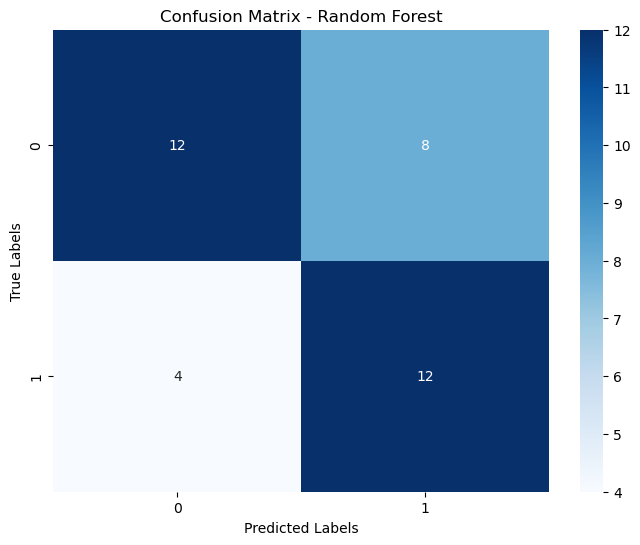

In [240]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_rel, y_rel, test_size=0.2, random_state=50)

# Initialize and train the Random Forest classifier
rf_rel.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_rel.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

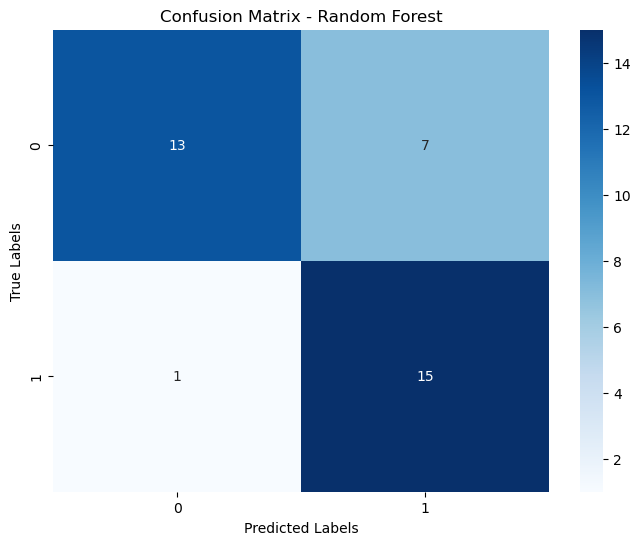

In [241]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_rel, y_rel, test_size=0.2, random_state=50)

# Initialize and train the Random Forest classifier
rf_rel_best.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_rel_best.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### Classifier for Arg2

In [234]:
db_arg2=for_class(final,"arg2")[0]
y_arg2=final["is_valuable_arg2"]

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_17943/4292264330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_17943/4292264330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['main_pos_counts'] = db[x].apply(count_main_pos_tags)


In [235]:
rf_arg2=RandomForestClassifier(random_state=42)
score_arg2 = cross_val_score(rf_arg2, db_arg2, y_arg2, cv=10,error_score='raise')
print(f"the average accuracy was: {score_arg2.mean()} and the complete score was: {score_arg2}")

the average accuracy was: 0.7682513661202186 and the complete score was: [0.78688525 0.7704918  0.73770492 0.75409836 0.8        0.76666667
 0.76666667 0.75       0.78333333 0.76666667]


In [152]:
rf_arg2.fit(db_arg2,y_arg2)

RandomForestClassifier(random_state=42)

In [153]:
from joblib import dump
dump(rf_arg2, 'model_file_2.joblib')

['model_file_2.joblib']

In [236]:
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [i for i in range(2, 10)],
    'min_samples_leaf': [i for i in range(1, 10)],
    'min_impurity_decrease': [i for i in np.arange(0, 0.1, 0.01)] 
    }

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_arg2, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring=make_scorer(loss, greater_is_better=False), random_state=42, verbose=2)
random_search.fit(db_arg2, y_arg2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.5s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.5s
[CV] END max_depth=None, min_i

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=42,
                   scoring=make_scorer(loss, greater_is_better=False),
                   verbose=2)

In [237]:
rf_arg2_best=RandomForestClassifier(**random_search.best_params_,random_state=42)
score_arg2_best = cross_val_score(rf_arg2_best, db_arg2, y_arg2, cv=10,error_score='raise')
print(f"the average accuracy was: {score_arg2_best.mean()} and the complete score was: {score_arg2_best}")

the average accuracy was: 0.7649453551912568 and the complete score was: [0.7704918  0.7704918  0.73770492 0.75409836 0.76666667 0.76666667
 0.76666667 0.76666667 0.78333333 0.76666667]


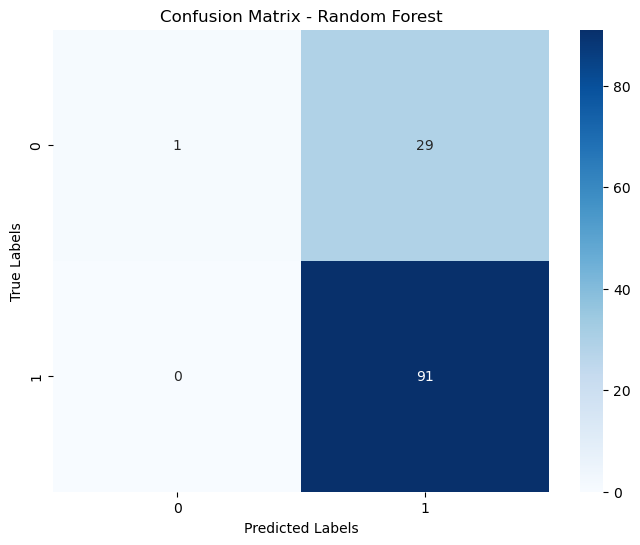

In [242]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_arg2, y_arg2, test_size=0.2, random_state=60)

# Initialize and train the Random Forest classifier
rf_arg2.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_arg2.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

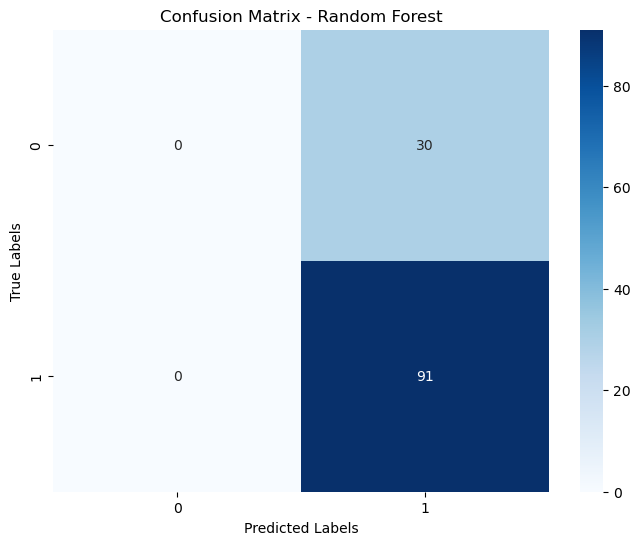

In [239]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_arg2, y_arg2, test_size=0.2, random_state=60)

# Initialize and train the Random Forest classifier
rf_arg2_best.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_arg2_best.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# NEW ATTEMPT WITH CLASSIFIER ON TOTAL SENTENCE

In [192]:
attempt=final.copy()
attempt["is_meaningful"]=[1 if sum(attempt.iloc[i,7:10])==3 else 0 for i in range(len(attempt))]
attempt.drop(["arg1","arg2","rel","is_valuable","is_valuable_rel","is_valuable_arg2"],axis=1,inplace=True)

<AxesSubplot: xlabel='is_meaningful', ylabel='count'>

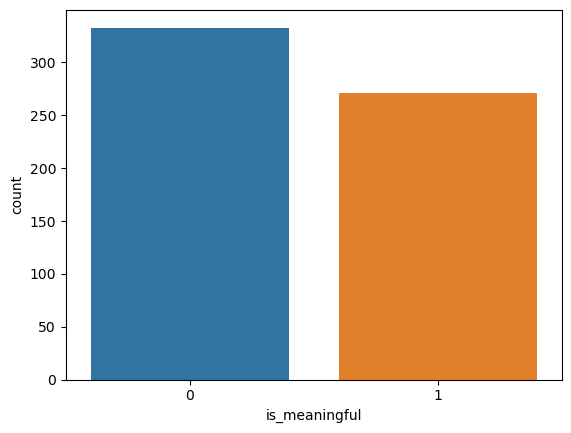

In [208]:
sns.countplot(x="is_meaningful", data=attempt)

In [206]:
def for_class_attempt(df):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    db = df.copy()
    db["length"]=db["sentence"].apply(lambda x: len(word_tokenize(x)))
    db['main_pos_counts'] = db["sentence"].apply(count_main_pos_tags)
    db = pd.concat([db.drop('main_pos_counts', axis=1), db['main_pos_counts'].apply(pd.Series)], axis=1)
    db["rel_nouns"]=db["Noun"]/db["length"]
    db["rel_pronouns"]=db["Pronoun"]/db["length"]
    db["rel_adjectives"]=db["Adjective"]/db["length"]
    db["rel_verbs"]=db["Verb"]/db["length"]
    db["rel_adverbs"]=db["Adverb"]/db["length"]
    db["rel_determiners"]=db["Determiner"]/db["length"]
    db["rel_numerals"]=db["Numeral"]/db["length"]
    db.loc[:, "sentence"] = db.loc[:, "sentence"].apply(lambda x: model.encode(x))
    embeddings_sentence = np.vstack(db.loc[:, "sentence"].values)
    len_sentence = np.expand_dims(db.loc[:, 'length'].values, axis=1)
    nouns=np.expand_dims(db.loc[:, 'Noun'].values, axis=1)
    pronouns=np.expand_dims(db.loc[:, 'Pronoun'].values, axis=1)
    adjectives=np.expand_dims(db.loc[:, 'Adjective'].values, axis=1)
    verbs=np.expand_dims(db.loc[:, 'Verb'].values, axis=1)
    rel_nouns=np.expand_dims(db.loc[:, 'rel_nouns'].values, axis=1)
    rel_pronouns=np.expand_dims(db.loc[:, 'rel_pronouns'].values, axis=1)
    rel_adjectives=np.expand_dims(db.loc[:, 'rel_adjectives'].values, axis=1)
    rel_verbs=np.expand_dims(db.loc[:, 'rel_verbs'].values, axis=1)
    rel_adverbs=np.expand_dims(db.loc[:, 'rel_adverbs'].values, axis=1)
    rel_determiners=np.expand_dims(db.loc[:, 'rel_determiners'].values, axis=1)
    rel_numerals=np.expand_dims(db.loc[:, 'rel_numerals'].values, axis=1)
    confidence=np.expand_dims(db.loc[:, 'confidence'].values, axis=1)
    passive=pd.get_dummies(db["passive"],drop_first=True)
    negated=pd.get_dummies(db["negated"],drop_first=True)
    db= np.hstack([embeddings_sentence, len_sentence, nouns, pronouns, adjectives, verbs, rel_nouns, rel_pronouns, 
                   rel_adjectives, rel_verbs, rel_adverbs, rel_determiners, rel_numerals, passive, negated, confidence])
    
    return db

In [207]:
db_sentence=for_class_attempt(attempt)
y_sentence=attempt["is_meaningful"]

In [209]:
rf_sentence=RandomForestClassifier(random_state=42)
score = cross_val_score(rf_sentence, db_sentence, y_sentence, cv=10,error_score='raise')
print(f"the average accuracy was: {score.mean()} and the complete score was: {score}")

the average accuracy was: 0.5360655737704918 and the complete score was: [0.60655738 0.57377049 0.63934426 0.54098361 0.46666667 0.58333333
 0.43333333 0.45       0.5        0.56666667]
